In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from transformers import CLIPModel, CLIPTokenizer
import sys
import os
sys.path.append(os.path.abspath('/home/user/dxc/motion/StableMoFusion/'))
from motion_loader import get_dataset_loader  
from tqdm import tqdm
import random
import yaml
from argparse import Namespace
from model import *
from eval import EvaluatorModelWrapper


In [2]:
from types import SimpleNamespace

# 原始字典
opt_dict = {
    'dataset_name': 't2m',
    'device': 'cuda:7',
    'dim_word': 300,
    'max_motion_length': 196,
    'dim_pos_ohot': 15,
    'dim_motion_hidden': 1024,
    'max_text_len': 20,
    'dim_text_hidden': 512,
    'dim_coemb_hidden': 512,
    'dim_pose': 263,  # 263 if dataset_name == 'humanml' else 251,
    'dim_movement_enc_hidden': 512,
    'dim_movement_latent': 512,
    'checkpoints_dir': '/home/user/dxc/motion/StableMoFusion/data/pretrained_models/',
    'unit_length': 4,
    'batch_size': 16,
    'meta_dir': "/home/user/dxc/motion/StableMoFusion/t2m_condunet1d_batch64/meta",
    'eval_meta_dir': "/home/user/dxc/motion/StableMoFusion/data",
    'glove_dir': "/home/user/dxc/motion/StableMoFusion/data/glove"
}

# 将字典转换为 SimpleNamespace 对象
opt = SimpleNamespace(**opt_dict)

# 测试通过属性访问值
print(opt.dataset_name)
eval_wrapper = EvaluatorModelWrapper(opt)

t2m

Loading Evaluation Model Wrapper (Epoch 28) Completed!!


In [13]:
sys.path.append(os.path.abspath('/home/user/dxc/motion/StableMoFusion'))

test_loader = get_dataset_loader(
    opt,
    batch_size=16,
    split='test',
    mode='gt_eval'
)
train_loader = get_dataset_loader(
    opt,
    batch_size=16,
    split='train',
    mode='gt_eval'
)


 Loading gt_eval mode HumanML3D dataset ...
/home/user/dxc/motion/StableMoFusion/data/t2m_std.npy


  0%|          | 0/4384 [00:00<?, ?it/s]

Completing loading t2m dataset

 Loading gt_eval mode HumanML3D dataset ...
/home/user/dxc/motion/StableMoFusion/data/t2m_std.npy


  0%|          | 0/23384 [00:00<?, ?it/s]

Completing loading t2m dataset


In [14]:
import numpy as np

motions = []
torch.cuda.empty_cache()


for batch_data in test_loader:
    torch.cuda.empty_cache()  
    caption, motion, m_length = batch_data
    motion = motion.to(opt.device)
    m_length = m_length.to(opt.device)
    with torch.no_grad():
        motion_embedding = eval_wrapper.get_motion_embeddings_train(motion, m_lens=m_length)


    

    
    motions.append(motion_embedding.cpu().numpy())  

    # 清理缓存并删除不再需要的变量
    del motion_embedding

    torch.cuda.empty_cache()

for batch_data in train_loader:
    torch.cuda.empty_cache()  
    caption, motion, m_length = batch_data
    motion = motion.to(opt.device)
    m_length = m_length.to(opt.device)
    with torch.no_grad():
        motion_embedding = eval_wrapper.get_motion_embeddings_train(motion, m_lens=m_length)


    

    
    motions.append(motion_embedding.cpu().numpy())  

    # 清理缓存并删除不再需要的变量
    del motion_embedding

    torch.cuda.empty_cache()

# 将所有的motion_emb拼接成一个numpy数组
motions_cat = np.concatenate(motions, axis=0)  # 在第一个维度拼接，形成n*768

print(motions_cat.shape)

# 清理motions列表，释放内存
del motions
torch.cuda.empty_cache()

/home/user/dxc/motion/StableMoFusion/eval/evaluator_wrapper.py:121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  m_lens = m_lens // 4


(29184, 512)


In [15]:
from scipy.stats import chi2, norm 

# Mardia多元正态性检验
mu = np.mean(motions_cat, axis=0)
cov = np.cov(motions_cat, rowvar=False)
n, d = motions_cat.shape

try:
    inv_cov = np.linalg.inv(cov)
except np.linalg.LinAlgError:
    inv_cov = np.linalg.pinv(cov)
    print("Warning: Using pseudo-inverse due to singular covariance matrix")

# 计算马氏距离平方
diff = motions_cat - mu
D_sq = np.einsum('...i,...i->...', diff @ inv_cov, diff)

# 计算偏度和峰度统计量
b1d = np.mean(D_sq**3)
b2d = np.mean(D_sq**2)

# 偏度检验（卡方分布）
skew_stat = n * b1d / 6
df_skew = d * (d + 1) * (d + 2) // 6
p_skew = chi2.sf(skew_stat, df_skew)

# 峰度检验（正态近似）
kurt_stat = (b2d - d * (d + 2)) / np.sqrt(8 * d * (d + 2) / n)
p_kurt = norm.sf(kurt_stat)

print(f"\nMardia's Test Results (d={d}, n={n}):")
print(f"Skewness: χ²({df_skew}) = {skew_stat:.2e}, p = {p_skew}")
print(f"Kurtosis: z = {kurt_stat:.2f}, p = {p_kurt}")


Mardia's Test Results (d=512, n=29184):
Skewness: χ²(22500864) = 1.86e+12, p = 0.0
Kurtosis: z = 11848.55, p = 0.0


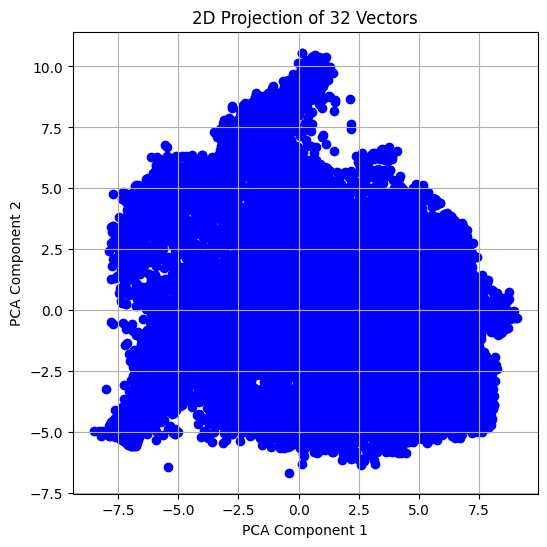

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



# 转换为numpy数组进行PCA
batch_data_np = motions_cat
# 使用PCA将数据降到二维
pca = PCA(n_components=2)
data_2d = pca.fit_transform(batch_data_np)

# 绘制二维散点图
plt.figure(figsize=(6, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c='blue', marker='o')
plt.title('2D Projection of 32 Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 假设 batch_data_np 是你的数据
tsne = TSNE(n_components=2, random_state=42)
data_2d_tsne = tsne.fit_transform(batch_data_np)

# 使用渐变色（例如：viridis）来表示每个点的不同
plt.figure(figsize=(8, 8), dpi=300)  # 提高分辨率
scatter = plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=np.linalg.norm(batch_data_np, axis=1), cmap='viridis', marker='o', alpha=0.6, s=10)

# 添加颜色条
#plt.colorbar(scatter, label='Vector Magnitude')

# plt.title('t-SNE Projection of all Vectors', fontsize=16)
# plt.xlabel('t-SNE Component 1', fontsize=14)
# plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)  # 设置淡灰色的网格线
plt.tight_layout()  # 自动调整布局以避免标签重叠
plt.show()

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 假设你有一个batch数据
batch_data = torch.randn(4640, 768)  # 这里用随机数生成32个1x768维度的向量

# 转换为numpy数组进行PCA
batch_data_np = batch_data.numpy()

# 使用PCA将数据降到二维
pca = PCA(n_components=2)
data_2d = pca.fit_transform(batch_data_np)

# 绘制二维散点图
plt.figure(figsize=(6, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c='blue', marker='o')
plt.title('2D Projection of 32 Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

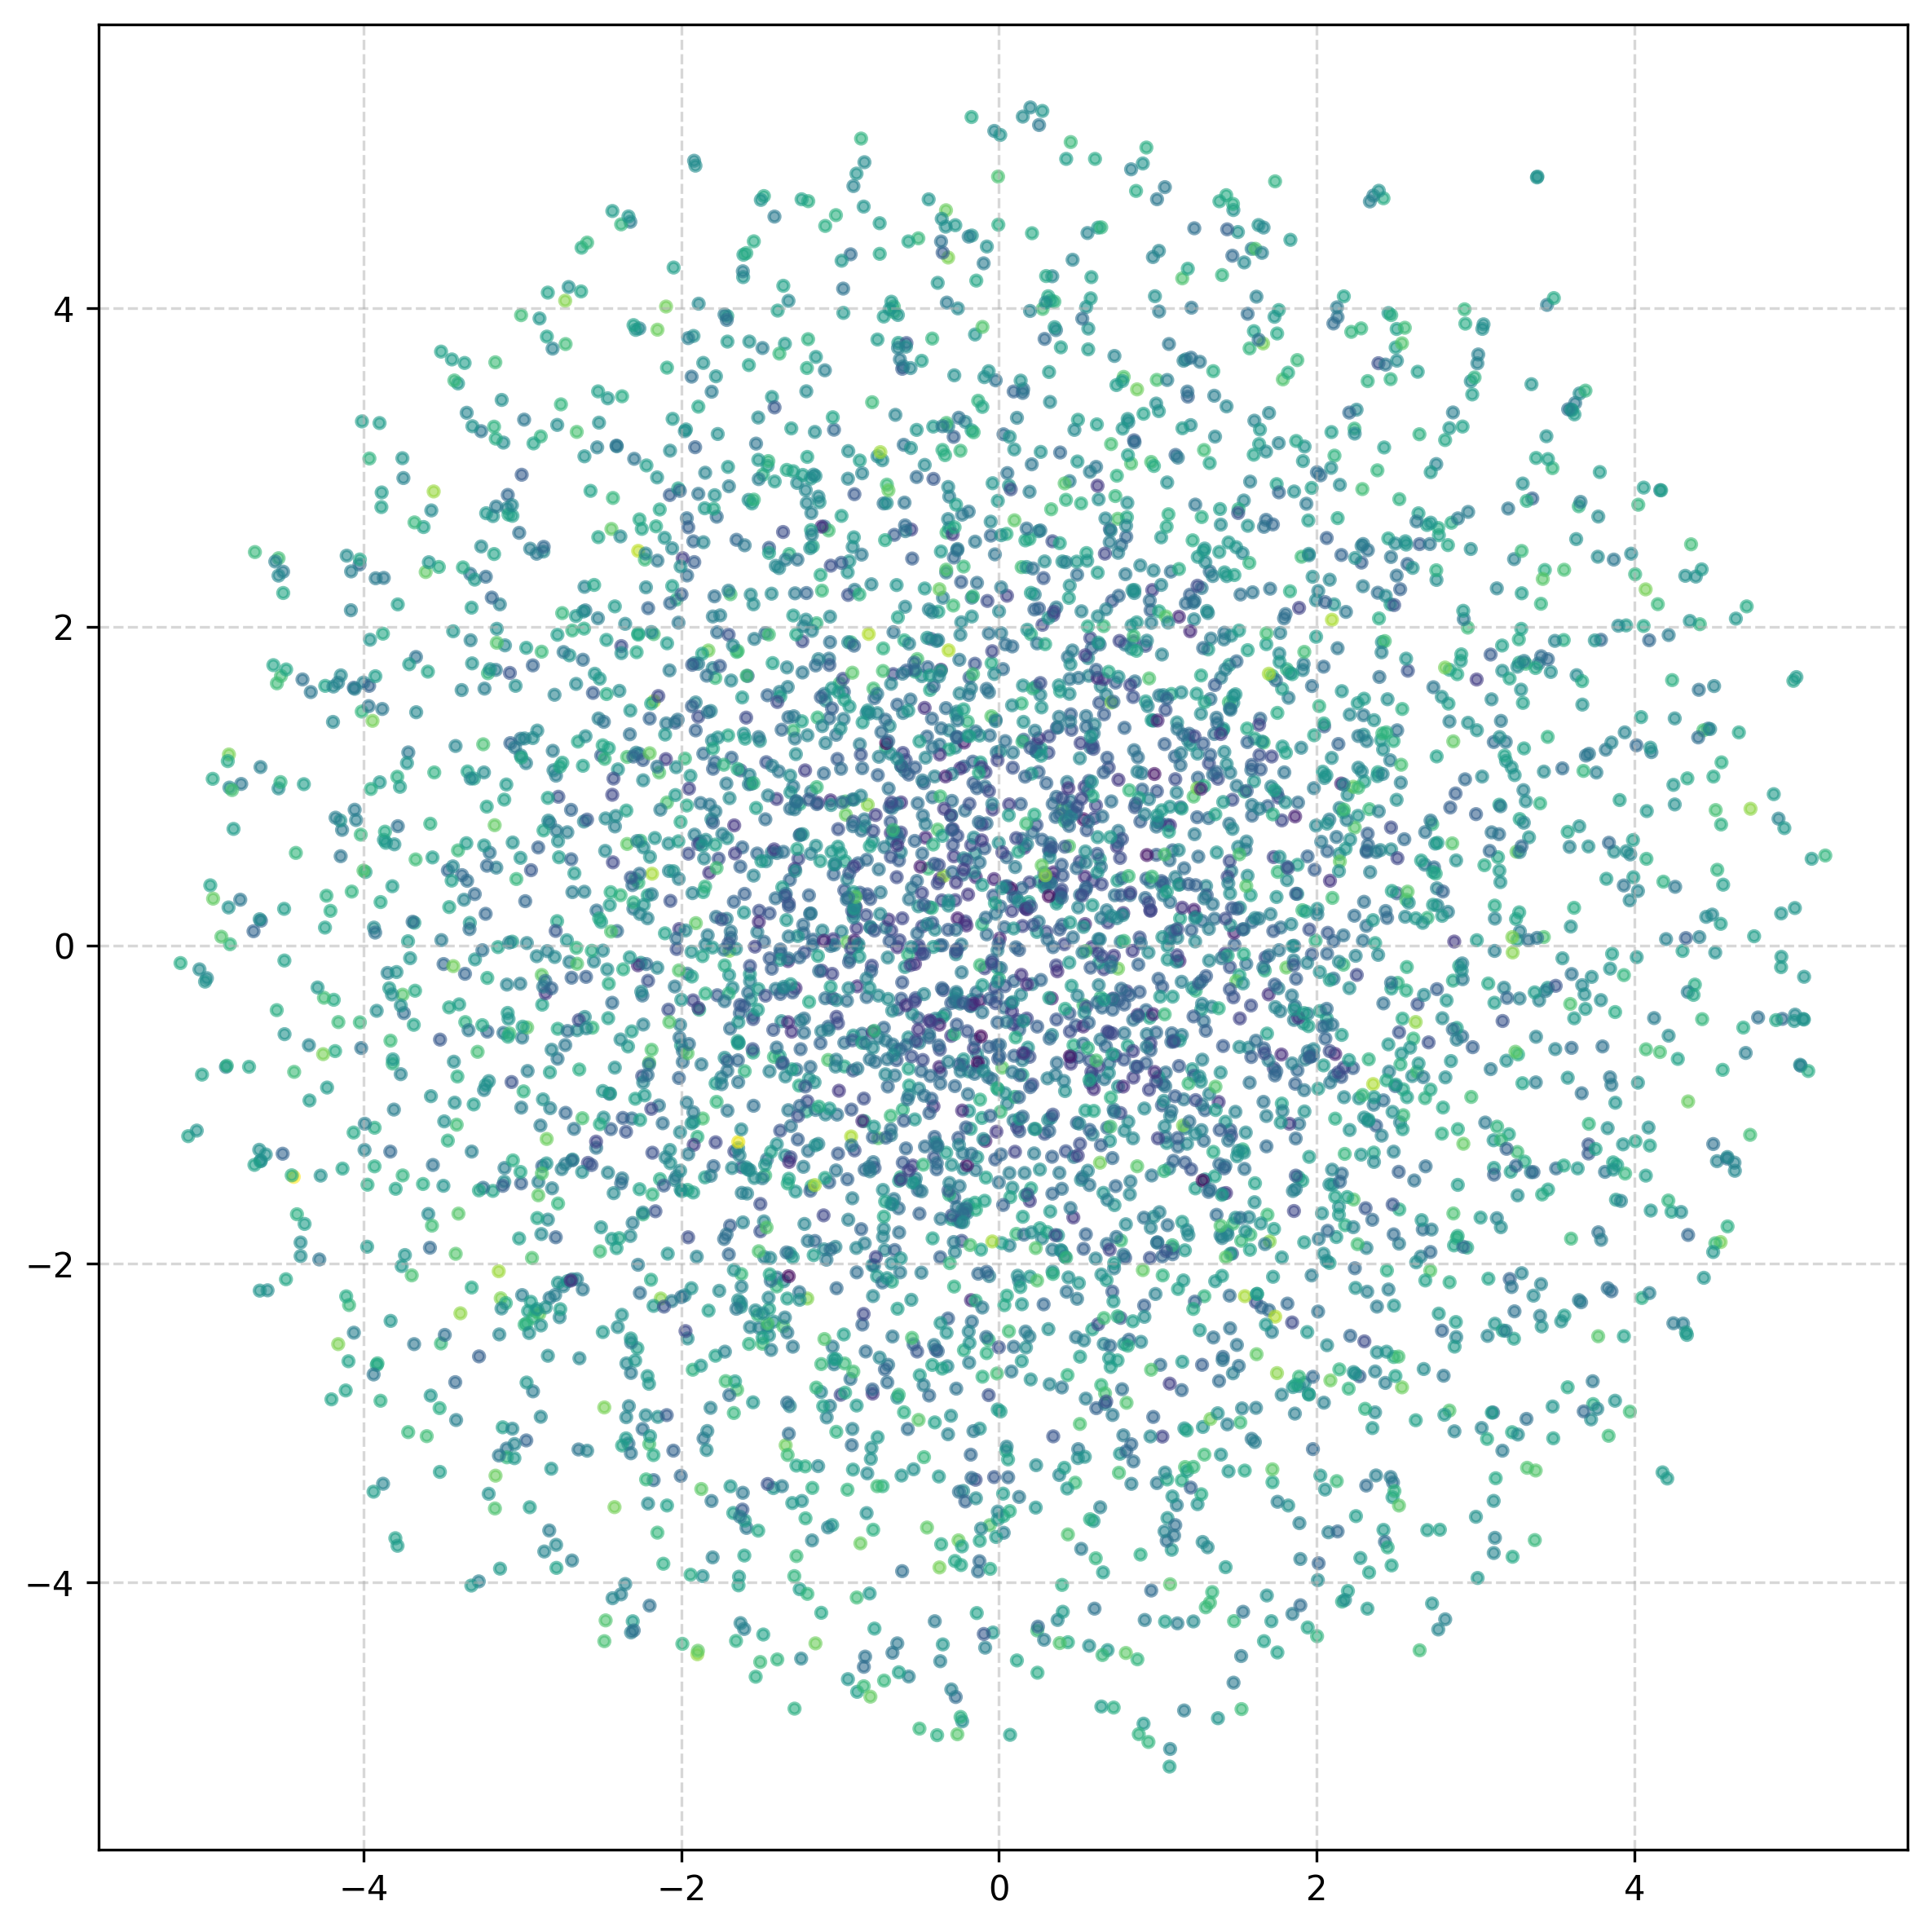

In [9]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 假设 batch_data_np 是你的数据
tsne = TSNE(n_components=2, random_state=42)
data_2d_tsne = tsne.fit_transform(batch_data_np)

# 使用渐变色（例如：viridis）来表示每个点的不同
plt.figure(figsize=(8, 8), dpi=300)  # 提高分辨率
scatter = plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=np.linalg.norm(batch_data_np, axis=1), cmap='viridis', marker='o', alpha=0.6, s=10)

# 添加颜色条
#plt.colorbar(scatter, label='Vector Magnitude')

# plt.title('t-SNE Projection of all Vectors', fontsize=16)
# plt.xlabel('t-SNE Component 1', fontsize=14)
# plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)  # 设置淡灰色的网格线
plt.tight_layout()  # 自动调整布局以避免标签重叠
plt.show()